In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split


In [3]:
(x_train, y_train), (x_test, y_test)= fashion_mnist.load_data()      #loading the dataset

x_train= x_train.reshape(x_train.shape[0], -1)                        #reshape the x into (60000, 784)
#y= y_train                                                            #y is already a 1D array

x_train= x_train.reshape(x_train.shape[0], -1)/255.0                        #normalizing x
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0                   # Normalize

def display_dataset_info(x_train, y_train, x_test, y_test):
    print("=" * 40)
    print("Fashion MNIST Dataset Details")
    print("=" * 40)
    print(f"Training Samples: {x_train.shape[0]}")
    print(f"Test Samples: {x_test.shape[0]}")
    print(f"Input Features: {x_train.shape[1]}")
    print(f"Number of Classes: {len(np.unique(y_train))}")
    print("=" * 40)

# Call the function
display_dataset_info(x_train, y_train, x_test, y_test)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Fashion MNIST Dataset Details
Training Samples: 60000
Test Samples: 10000
Input Features: 784
Number of Classes: 10


In [4]:
# Define activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))  # Normalize
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)


In [15]:
# Optimizer Class

class Optimizer:
    def __init__(self, learning_rate=0.01, epsilon=1e-4, beta=0.9, beta1= 0.9, beta2= 0.999):
      self.learning_rate= learning_rate
      self.epsilon= epsilon
      self.beta= beta
      self.beta1= beta1
      self.beta2= beta2


    def sgd(self, parameters, grads, prev_u= None):
      for t in parameters.keys():
        parameters[t] -= self.learning_rate* grads[ t]

      return parameters, prev_u



    def momentum_gradient_descent(self, parameters, grads, prev_u=None, beta=0.9):
      if prev_u is None:
        prev_u = {key: np.zeros_like(value) for key, value in parameters.items()}  # Initialize with zeros (u(-1)= 0)

      for t in parameters.keys():
          prev_u[t]= beta * prev_u[t] +  grads[t]
          parameters[t] -= self.learning_rate* prev_u[t]                     #prev_u[t] accumuklates the history vector

      return parameters, prev_u



    def nesterov_accelerated_gradient_descent(self, parameters, grads, prev_u= None, beta=0.9):
      if prev_u is None:
        prev_u= {t: np.zeros_like(value) for t, value in parameters.items()}     # initialize u(-1)= 0

      lookahead_params = {t: parameters[t] - beta * prev_u[t] for t in parameters.keys()}

      temp_grads = grads
      for t in parameters.keys():
        prev_u[t]= beta * prev_u[t] + self.learning_rate * temp_grads[t]         #prev_u[t] accumuklates the history vector
        parameters[t] -= prev_u[t]
      return parameters, prev_u


    def rmsprop(self, parameters, grads, prev_u= None, beta= 0.9):
      if prev_u is None:
        prev_u = {t: np.zeros_like(value) for t, value in parameters.items()}    # initialize u(-1)= 0

      for t in parameters.keys():
        prev_u[t]= beta * prev_u[t] + (1 - beta) * grads[t] ** 2

        parameters[t] -= (self.learning_rate / (np.sqrt(prev_u[t]) + self.epsilon)) * grads[t]

      return parameters, prev_u
       #adam

    def adam(self, parameters, grads, prev_u=None):
      if prev_u is None or "step" not in prev_u:           #initialization
        prev_u = {"m": {t: np.zeros_like(value) for t, value in parameters.items()},
                      "v": {t: np.zeros_like(value) for t, value in parameters.items()},
                      "step": 0
                  }

      prev_u["step"] += 1                                   #time step increment
      step= prev_u["step"]

      for t in parameters.keys():
        prev_u["m"][t]=  self.beta1 * prev_u["m"][t] + (1 - self.beta1) * grads[t]                  #update rule
        prev_u["v"][t]= self.beta2 * prev_u["v"][t] + (1 - self.beta2) * (grads[t] ** 2)

        m_hat= prev_u["m"][t] / (1 - self.beta1 ** step)
        v_hat = prev_u["v"][t] / (1 - self.beta2 ** step)

        parameters[t] -= (self.learning_rate * m_hat) / (np.sqrt(v_hat) + self.epsilon)          #parameter update


      return parameters, prev_u


    #nadam
    def nadam(self, parameters, grads, prev_u=None):
      if prev_u is None or "step" not in prev_u:                   #initialization
        prev_u=  { "m": {t: np.zeros_like(value) for t, value in parameters.items()},
                      "v": {t: np.zeros_like(value) for t, value in parameters.items()},
                      "step": 0
             }
      prev_u["step"] += 1                                           #time step increment
      step= prev_u["step"]

      for t in parameters.keys():
        prev_u["m"][t]=  self.beta1 * prev_u["m"][t] + (1 - self.beta1) * grads[t]               #update rule
        prev_u["v"][t] = self.beta2 * prev_u["v"][t] + (1 - self.beta2) * (grads[t] ** 2)

        m_hat= prev_u["m"][t] / (1 - self.beta1 ** step)
        v_hat= prev_u["v"][t] / (1 - self.beta2 ** step)

        nadam_update= (self.beta1 * m_hat + (1 - self.beta1) * grads[t] / (1 - self.beta1 ** step))     #
        parameters[t] -= (self.learning_rate / (np.sqrt(v_hat) + self.epsilon)) * nadam_update          #parameter update


      return parameters, prev_u






In [16]:

# Neural Network Class
class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.parameters = self.initialize_weights_bias(layer_sizes)
        self.layer_sizes = layer_sizes

    def initialize_weights_bias(self, layer_size):
        parameters = {}
        L = len(layer_size) - 1  # Exclude the input layer

        for i in range(1, L + 1):
            parameters[f"W{i}"] = np.random.randn(layer_size[i], layer_size[i - 1])  # Initialize W randomly
            parameters[f"b{i}"] = np.random.randn(layer_size[i], 1)                 # Initialize b randomly, column vector

        return parameters

    def forward_propagation(self, x_train, y_train, num_of_hidden_layers, num_of_neurons):
        N = len(np.unique(y_train))
        input_dimension = x_train.shape[1]                  # Number of features per sample
        layer_size = [input_dimension] + [num_of_neurons] * num_of_hidden_layers + [N]

        parameters = self.initialize_weights_bias(layer_size)  # Initialize weights & biases

        pre_activations = {}
        activations = {"h0": x_train.T}                        # Input layer activation

        for i in range(1, num_of_hidden_layers + 1):
            a_i = np.dot(self.parameters[f"W{i}"], activations[f"h{i-1}"]) + self.parameters[f"b{i}"]
            h_i = sigmoid(a_i)

            pre_activations[f"a{i}"] = a_i
            activations[f"h{i}"] = h_i

        # Output layer forward pass
        L = num_of_hidden_layers + 1
        a_L = np.dot(self.parameters[f"W{L}"], activations[f"h{L - 1}"]) + self.parameters[f"b{L}"]
        h_L = softmax(a_L)                                   # Final output

        pre_activations[f"a{L}"] = a_L
        activations[f"h{L}"] = h_L

        return h_L.T, pre_activations, activations

    def train_test_split(self, x_train, y_train, test_size=0.2, random_state=42):
        return train_test_split(x_train, y_train, test_size=test_size, random_state=random_state)

    def backpropagation(self, x_train, y_train, parameters, pre_activations, activations, optimizer, batch_size, prev_v):
        N = len(np.unique(y_train))
        y_one_hot = np.eye(N)[y_train].T
        grads = {}
        L = len(self.layer_sizes) - 1

        #talk to the output layer

        nabla_a_L = activations[f"h{L}"] - y_one_hot                                    #gradient wrt the last layer
        grads[f"W{L}"] = np.dot(nabla_a_L, activations[f"h{L-1}"].T) / batch_size
        grads[f"b{L}"] = np.sum(nabla_a_L, axis=1, keepdims=True) / batch_size

        for k in range(L - 1, 0, -1):                                        #talk to the hidden layer
            nabla_h_k = np.dot(parameters[f"W{k+1}"].T, nabla_a_L)                      #gradients wrt the hidden layers
            nabla_a_k = nabla_h_k * sigmoid_derivative(pre_activations[f"a{k}"])
            grads[f"W{k}"] = np.dot(nabla_a_k, activations[f"h{k-1}"].T) / batch_size   #gradient wrt the weights
            grads[f"b{k}"] = np.sum(nabla_a_k, axis=1, keepdims=True) / batch_size      #gradient wrt the bias
            nabla_a_L = nabla_a_k

        self.parameters, prev_v = optimizer(self.parameters, grads, prev_v)
        return parameters, prev_v
     # training the model
    def train_model(self, x_train, y_train, num_hidden_layers, num_neurons, optimizer_type, learning_rate, num_epochs, batch_size):
      input_dim= x_train.shape[1]
      num_classes = len(np.unique(y_train))
      self.layer_sizes = [input_dim] + [num_neurons] * num_hidden_layers + [num_classes]
      self.parameters = self.initialize_weights_bias(self.layer_sizes)
      optimizer_instance = Optimizer(learning_rate)
      prev_v = {key: np.zeros_like(value) for key, value in self.parameters.items()}
      losses = []

      if hasattr(optimizer_instance, optimizer_type):     #checking if the optimizer is present in the "Optimizer " class
        optimizer = getattr(optimizer_instance, optimizer_type)
      else:
        raise ValueError(f"Optimizer '{optimizer_type}' is not defined in Optimizer class.")

      for epoch in range(num_epochs):
        y_hat, pre_activations, activations = self.forward_propagation(x_train, y_train, num_hidden_layers, num_neurons)
        self.parameters, prev_v = self.backpropagation(x_train, y_train, self.parameters, pre_activations, activations, optimizer, batch_size, prev_v)


        #  loss calculation

        loss = -np.mean(np.log(y_hat[np.arange(len(y_train)), y_train]))



        losses.append(loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

      # Compute final training accuracy
      train_predictions = np.argmax(y_hat, axis=1)  # Get predicted class
      train_accuracy = np.mean(train_predictions == y_train) * 100  # Compute accuracy
      print(f"Final Training Accuracy: {train_accuracy:.2f}%")

      plt.plot(losses)
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.title("Training Loss")
      plt.show()

      return train_accuracy, losses





    def test_model(self, x_test, y_test, num_hidden_layers, num_neurons, batch_size):
        input_dim = x_test.shape[1]
        num_classes = len(np.unique(y_test))
        self.layer_sizes = [input_dim] + [num_neurons] * num_hidden_layers + [num_classes]
        y_hat, _, _ = self.forward_propagation(x_test, y_test, num_hidden_layers, num_neurons)

        if y_hat.shape[0] != x_test.shape[0]:    #shape (n_samples, n_classes)
          y_hat= y_hat.T

        test_predictions = np.argmax(y_hat, axis=1)
        min_length = min(len(test_predictions), len(y_test))


        accuracy = np.mean(test_predictions[:min_length] == y_test[:min_length]) * 100

        print(f"Test Accuracy: {accuracy:.2f}%")
        return accuracy


Epoch 1/250, Loss: 7.5795
Epoch 2/250, Loss: 7.0798
Epoch 3/250, Loss: 6.5965
Epoch 4/250, Loss: 6.1333
Epoch 5/250, Loss: 5.6955
Epoch 6/250, Loss: 5.2902
Epoch 7/250, Loss: 4.9250
Epoch 8/250, Loss: 4.6063
Epoch 9/250, Loss: 4.3369
Epoch 10/250, Loss: 4.1152
Epoch 11/250, Loss: 3.9349
Epoch 12/250, Loss: 3.7867
Epoch 13/250, Loss: 3.6611
Epoch 14/250, Loss: 3.5499
Epoch 15/250, Loss: 3.4474
Epoch 16/250, Loss: 3.3498
Epoch 17/250, Loss: 3.2557
Epoch 18/250, Loss: 3.1645
Epoch 19/250, Loss: 3.0766
Epoch 20/250, Loss: 2.9929
Epoch 21/250, Loss: 2.9142
Epoch 22/250, Loss: 2.8412
Epoch 23/250, Loss: 2.7741
Epoch 24/250, Loss: 2.7128
Epoch 25/250, Loss: 2.6565
Epoch 26/250, Loss: 2.6042
Epoch 27/250, Loss: 2.5546
Epoch 28/250, Loss: 2.5068
Epoch 29/250, Loss: 2.4597
Epoch 30/250, Loss: 2.4128
Epoch 31/250, Loss: 2.3657
Epoch 32/250, Loss: 2.3184
Epoch 33/250, Loss: 2.2710
Epoch 34/250, Loss: 2.2241
Epoch 35/250, Loss: 2.1778
Epoch 36/250, Loss: 2.1328
Epoch 37/250, Loss: 2.0894
Epoch 38/2

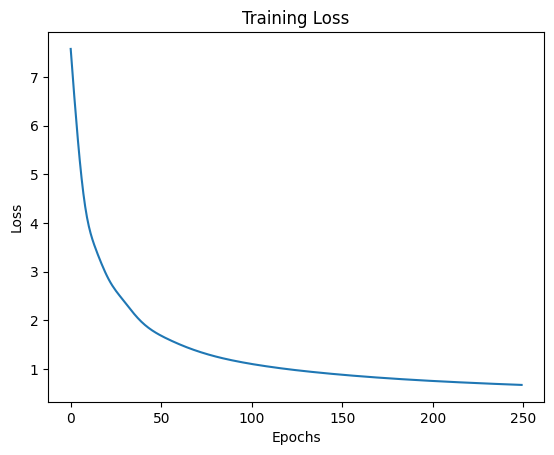

Test Accuracy: 73.30%
Final Training Accuracy: 76.43%
Final Test Accuracy: 73.30%


In [19]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

# Initialize  with hidden layers easily
nn = NeuralNetwork([x_train.shape[1]] + [70] * 4 + [len(np.unique(y_train))])

# Train model function call
#train_acc, loss_history = nn.train_model(x_train, y_train, 4, 70, 'nesterov_accelerated_gradient_descent', 0.001, 250, 64)
#train_acc, loss_history = nn.train_model(x_train, y_train, 4, 70, 'rmsprop', 0.001, 250, 64)
#train_acc, loss_history = nn.train_model(x_train, y_train, 4, 70, 'nadam', 0.001, 250, 64)
train_acc, loss_history = nn.train_model(x_train, y_train, 4, 70, 'adam', 0.001, 250, 64)

# Compute test accuracy using the trained model
test_acc = nn.test_model(x_test, y_test, 4, 70, batch_size=64)

# Print final accuracies
print(f"Final Training Accuracy: {train_acc:.2f}%")
print(f"Final Test Accuracy: {test_acc:.2f}%")
